# Hydroglaciology

In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from datetime import datetime
import obspy

In [2]:
direct = 'D:\MEMOIRE\HYDRO'
stt_gauging = '\V550\Vdv_data_20221116122909'
stt_temp = '\V159\Vdv_data_20221116124304'

In [3]:
gauging_time = []
gauging_velos = []

with open(direct+stt_gauging+'.csv') as file :
    readcsv = csv.reader(file, delimiter=';')
    line = 0
    for row in readcsv :
        if line > 4 :
            gauging_date = datetime.strptime(str(row[0]), '%Y-%m-%d %H:%M:%S')
            gauging_time.append(gauging_date)
            gauging_velos.append(float(row[3].replace(',','.')))
            
        line += 1

temp_time = []
temp = []

with open(direct+stt_temp+'.csv') as file :
    readcsv = csv.reader(file, delimiter=';')
    line = 0
    for row in readcsv :
        if line > 4 :
            temp_date = datetime.strptime(str(row[0]), '%Y-%m-%d %H:%M:%S')
            temp_time.append(temp_date)
            temp.append(float(row[1].replace(',','.')))
            
        line += 1

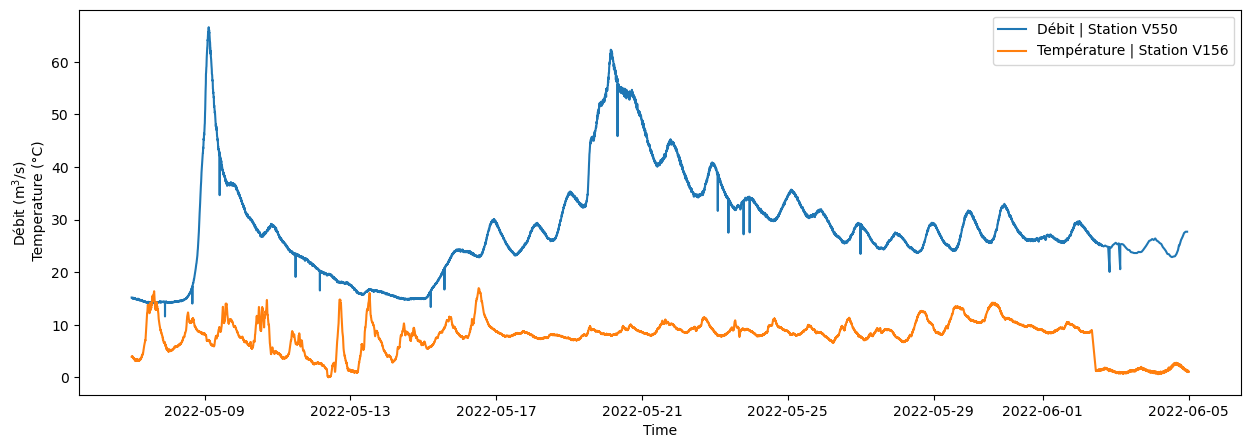

In [4]:
fig = plt.figure(figsize=(15, 5))
plt.plot(gauging_time, gauging_velos, label = 'Débit | Station V550')
plt.plot(temp_time, temp, label = 'Température | Station V156')
plt.xlabel('Time')
plt.ylabel('Débit (m$^3$/s) \n Temperature (°C)')
plt.legend()
plt.show()

### Determining the frequency of the signal
Crédit :
https://stackoverflow.com/questions/27673496/python-numpy-fft-or-rfft-to-find-period-of-a-wave-instead-of-its-frequiency

In [35]:
#sample_rate = 180
temp = np.array(temp)
amp_temp =np.abs(np.fft.rfft(temp, n=temp.size))
freq_temp = np.fft.rfftfreq(temp.size, d=1/480)
amp_temp[0] = 0
idx = amp_temp.argmax()
print(freq_temp[idx])

0.145631067961


In [36]:
#sample_rate = 180
gauging_velos = np.array(gauging_velos)
amp_gauging_velos =np.abs(np.fft.rfft(gauging_velos, n=gauging_velos.size))
freq_gauging_velos = np.fft.rfftfreq(gauging_velos.size, d=1/288)
amp_gauging_velos[0] = 0
idx = amp_gauging_velos.argmax()
print(freq_gauging_velos[idx])

0.0371517027864


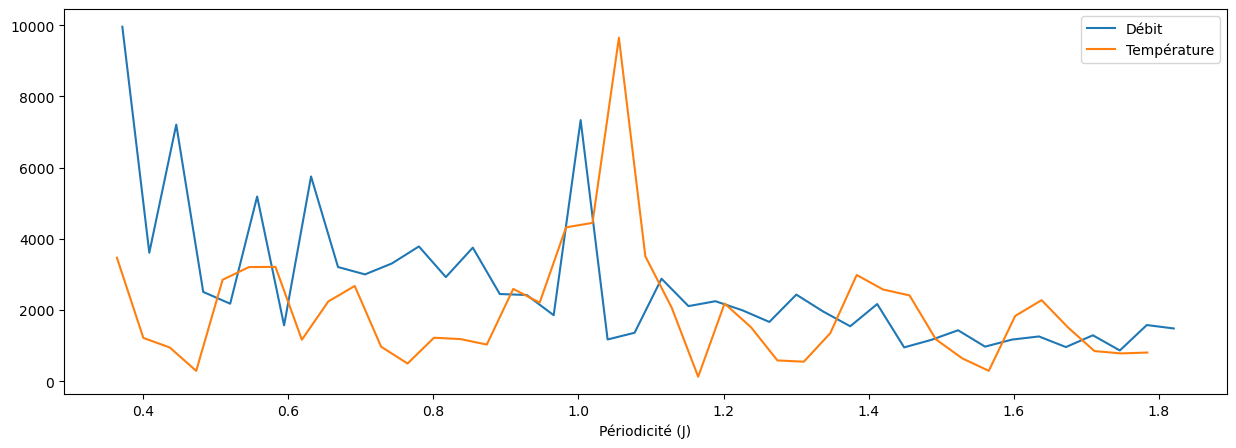

In [45]:
fig = plt.figure(figsize=(15, 5))
plt.plot(freq_gauging_velos[10:50], amp_gauging_velos[10:50], label="Débit")
plt.plot(freq_temp[10:50], amp_temp[10:50] , label="Température")
plt.xlabel('Périodicité (J)')
plt.legend()
plt.show()
